# Final Exercice: The Rumos Bank 

The Rumos Bank é um banco que tem perdido bastante dinheiro devido à quantidade de créditos que fornece e que não são pagos dentro do prazo devido. 

    - Por cada cliente que se estima que não irá  pagar dentro do prazo e afinal paga, o banco tem um custo de 1000euros. 

    - Por cada cliente que se prevê como sendo um bom pagador e afinal não paga dentro do prazo, o banco tem um custo de 3000euros.


Vocês, data scientists de topo,  são contratados para ajudar o banco a prever quais os clientes que não irão cumprir os prazos, para que este consiga uma melhor gestão dos fundos.

Conseguem construir um modelo que ajude a detectar previamente e com sucesso os clientes que são maus pagadores?


Dataset: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Variáveis disponíveis:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?
    3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?
    4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?
    5. Qual seria o custo que o banco tem sem nenhum modelo?
    6. Qual o custo que o banco passa a tar com o vosso modelo?

Com base na informação dada, podemos definir que:

    True positive - Os maus pagadores são identificados correctamente.
    True negative - Os bons pagadores são identificados correctamente.
    False positive - Um bom pagador é identificado como sendo um mau pagador.
    False negative - Um mau pagador é identificado como sendo um bom pagador.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

seed = 42

In [3]:
import mlflow
import mlflow.sklearn

# Diretoria local para guardar as experiências
mlflow.set_tracking_uri(r"file:C:\Users\vferreir\OneDrive - Ensign Bickford Industries, Inc\Documents\Courses_attended\PG_DataDcience\7.Operacionalizacao_ML\OML_final_project\mlruns")

# Nome da experiência (será criada se ainda não existir)
mlflow.set_experiment("Rumos Bank Experiment")


2025/04/24 15:47:39 INFO mlflow.tracking.fluent: Experiment with name 'Rumos Bank Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:C:\\Users\\vferreir\\OneDrive - Ensign Bickford Industries, '
 'Inc\\Documents\\Courses_attended\\PG_DataDcience\\7.Operacionalizacao_ML\\OML_final_project\\mlruns/773736397415668486'), creation_time=1745506059569, experiment_id='773736397415668486', last_update_time=1745506059569, lifecycle_stage='active', name='Rumos Bank Experiment', tags={}>

In [4]:
df = pd.read_csv('../data/lending_data.csv')


In [5]:
df.shape

(30000, 25)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
df.ID.nunique()

30000

#### 1. Quantas features estão disponíveis? Quantos clientes?

    - Existem 24 features disponíveis no dataset.
    - Existem 30000 clientes.

Existem missing values?

In [8]:
df.isnull().values.any()

np.False_

Existem o mesmo número de clientes nas duas classes?

In [9]:
df.groupby('default.payment.next.month')['default.payment.next.month'].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Não! O dataset é altamente desequilibrado.

#### 2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?

    - 23,364 foram bons pagadores. 6,636 foram maus pagadores.

Existem features não númericas?

In [10]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

Todas as features são númericas.

Vamos retirar o ID do cliente:

In [11]:
df = df.drop('ID', axis = 1)

Vamos então dividir o dataset em treino e teste:

In [12]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed)

In [13]:
X_train = train_set.drop(['default.payment.next.month'], axis = 'columns')
y_train = train_set['default.payment.next.month']

X_test = test_set.drop(['default.payment.next.month'], axis = 1)
y_test = test_set['default.payment.next.month']

Normalização:

In [14]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

Antes de iniciar, vamos calcular a baseline, ou seja, o custo que temos sem nenhum modelo.

$$totalCost = 1000∗FP+3000∗FN$$

In [15]:
y_preds_all_bad = np.ones(y_test.shape) 

In [16]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


In [17]:
print('Total Cost:', fp*1000)

Total Cost: 4687000


In [18]:
accuracy_score(y_test, y_preds_all_bad)

0.21883333333333332

Se todos os clientes fossem considerados como maus pagadores, o banco teria um custo de 4,687,000 Euros.

In [19]:
y_preds_all_good = np.zeros(y_test.shape) 

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


In [20]:
print('Total Cost:', fn*3000)

Total Cost: 3939000


In [21]:
accuracy_score(y_test, y_preds_all_good)

0.7811666666666667

Se todos os clientes fossem considerados bons pagadores, o banco teria um custo de 3,939,000 Euros.

In [22]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp
    

In [25]:
def min_cost_threshold(y_test, y_preds):
    
    costs = {}
    
    for threshold in np.arange(0, 1.1, 0.1):
        
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)
        
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()

    return min(costs, key=costs.get)
    

#### Logistic Regression

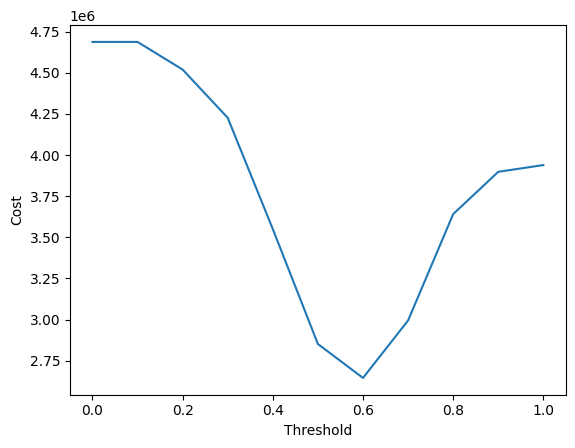

2025/04/24 15:51:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhor parâmetro C: 0.1
Acurácia: 0.694 | F1: 0.467
Total cost (0.5): 2852000
Threshold com custo mínimo: 0.60 | Custo: 2646000


In [26]:
with mlflow.start_run(run_name="Logistic Regression"):
    # Modelo base e parâmetros
    lr = LogisticRegression(max_iter=500, solver='lbfgs', random_state=seed, class_weight='balanced')
    parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    
    # Treinar com GridSearchCV
    clf_lr = GridSearchCV(lr, parameters, cv=5).fit(X_train, y_train)
    
    # Previsões
    y_preds_proba = clf_lr.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    # Métricas clássicas
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Métricas de custo
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)
    cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)

    # Log MLflow
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("solver", "lbfgs")
    mlflow.log_param("best_C", clf_lr.best_params_['C'])
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Guardar modelo
    mlflow.sklearn.log_model(clf_lr.best_estimator_, "model")

    print(f"Melhor parâmetro C: {clf_lr.best_params_['C']}")
    print(f"Acurácia: {acc:.3f} | F1: {f1:.3f}")
    print(f"Total cost (0.5): {cost_0_5}")
    print(f"Threshold com custo mínimo: {threshold_min_cost:.2f} | Custo: {cost_at_min}")


#### KNN

c:\ProgramData\anaconda3\envs\OML-project\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\envs\OML-project\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\OML-project\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\OML-project\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\envs\OML-project\Lib\

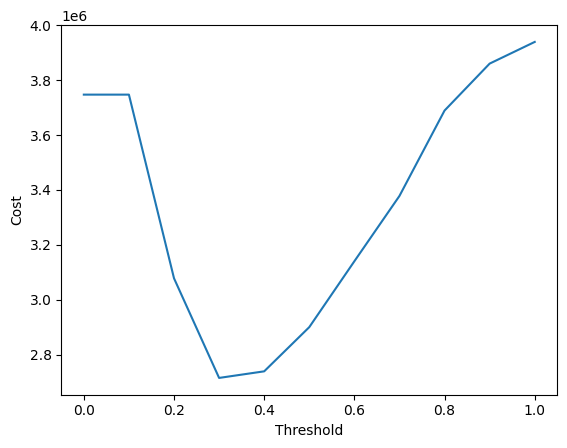

2025/04/24 16:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhor k: 9
Acurácia: 0.807 | F1: 0.433
Total cost (0.5): 2900000
Threshold com custo mínimo: 0.30 | Custo: 2715000


In [30]:
with mlflow.start_run(run_name="K-Nearest Neighbors"):
    # Modelo e parâmetros
    knn = KNeighborsClassifier()
    parameters = {'n_neighbors': range(1, 10)}

    # GridSearchCV
    clf_knn = GridSearchCV(knn, parameters, cv=5).fit(X_train, y_train)

    # Previsões
    y_preds_proba = clf_knn.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    # Métricas clássicas
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Métricas de custo
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)

    # Verificação do threshold
    if threshold_min_cost is not None:
        cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)
    else:
        threshold_min_cost = -1
        cost_at_min = -1

    # Registos no MLflow
    mlflow.log_param("model", "KNeighborsClassifier")
    mlflow.log_param("best_k", clf_knn.best_params_['n_neighbors'])
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Guardar modelo
    mlflow.sklearn.log_model(clf_knn.best_estimator_, "model")

    # Print
    print(f"Melhor k: {clf_knn.best_params_['n_neighbors']}")
    print(f"Acurácia: {acc:.3f} | F1: {f1:.3f}")
    print(f"Total cost (0.5): {cost_0_5}")
    print(f"Threshold com custo mínimo: {threshold_min_cost:.2f} | Custo: {cost_at_min}")


#### SVM

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

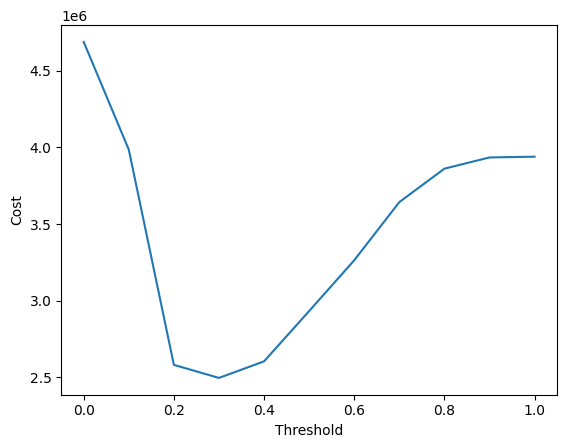

2025/04/24 17:07:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhores parâmetros: C=0.1 | kernel=rbf
Acurácia: 0.815 | F1: 0.434
Total cost (0.5): 2933000
Threshold com custo mínimo: 0.30 | Custo: 2497000


In [31]:
with mlflow.start_run(run_name="Support Vector Machine"):
    # Definir o modelo base e os parâmetros para GridSearchCV
    svc = SVC(random_state=seed, class_weight='balanced', gamma='scale', probability=True, verbose=True)
    parameters = {'C': [0.1, 1, 10], 'kernel': ('rbf', 'linear')}

    # GridSearchCV
    clf_svc = GridSearchCV(svc, parameters, cv=5).fit(X_train, y_train)

    # Previsões
    y_preds_proba = clf_svc.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    # Métricas clássicas
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Métricas de custo
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)
    if threshold_min_cost is not None:
        cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)
    else:
        threshold_min_cost = -1
        cost_at_min = -1

    # Registos no MLflow
    mlflow.log_param("model", "SVC")
    mlflow.log_param("best_C", clf_svc.best_params_['C'])
    mlflow.log_param("best_kernel", clf_svc.best_params_['kernel'])

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Guardar o modelo
    mlflow.sklearn.log_model(clf_svc.best_estimator_, "model")

    # Print no final
    print(f"Melhores parâmetros: C={clf_svc.best_params_['C']} | kernel={clf_svc.best_params_['kernel']}")
    print(f"Acurácia: {acc:.3f} | F1: {f1:.3f}")
    print(f"Total cost (0.5): {cost_0_5}")
    print(f"Threshold com custo mínimo: {threshold_min_cost:.2f} | Custo: {cost_at_min}")


#### Decision Trees

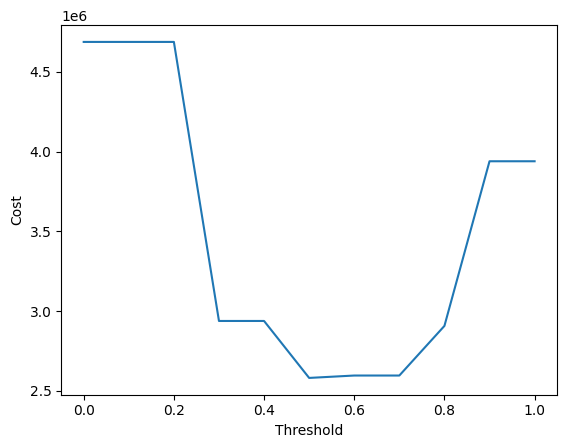

2025/04/24 20:15:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhores parâmetros: max_depth=3, min_samples_split=2
Acurácia: 0.761 | F1: 0.508
Total cost (0.5): 2581000
Threshold com custo mínimo: 0.50 | Custo: 2581000


In [32]:
with mlflow.start_run(run_name="Decision Tree"):
    # Modelo base e parâmetros para o GridSearch
    trees = tree.DecisionTreeClassifier(random_state=seed, class_weight='balanced')
    parameters = {'max_depth': [3, 6], 'min_samples_split': [2, 4, 10]}

    # Treinar com GridSearchCV
    clf_tree = GridSearchCV(trees, parameters, cv=5).fit(X_train, y_train)

    # Previsões
    y_preds_proba = clf_tree.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    # Métricas clássicas
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Métricas de custo
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)
    if threshold_min_cost is not None:
        cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)
    else:
        threshold_min_cost = -1
        cost_at_min = -1

    # Registos no MLflow
    mlflow.log_param("model", "DecisionTreeClassifier")
    mlflow.log_param("best_max_depth", clf_tree.best_params_['max_depth'])
    mlflow.log_param("best_min_samples_split", clf_tree.best_params_['min_samples_split'])

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Guardar modelo
    mlflow.sklearn.log_model(clf_tree.best_estimator_, "model")

    # Print resumo
    print(f"Melhores parâmetros: max_depth={clf_tree.best_params_['max_depth']}, min_samples_split={clf_tree.best_params_['min_samples_split']}")
    print(f"Acurácia: {acc:.3f} | F1: {f1:.3f}")
    print(f"Total cost (0.5): {cost_0_5}")
    print(f"Threshold com custo mínimo: {threshold_min_cost:.2f} | Custo: {cost_at_min}")


#### Random Forests

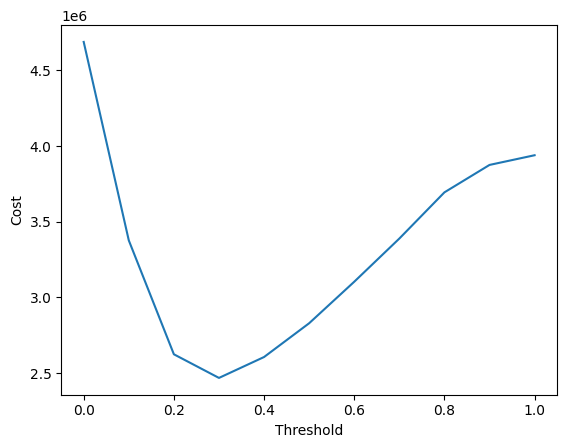

2025/04/24 20:22:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhor número de estimadores: 1000
Acurácia: 0.817 | F1: 0.451
Total cost (0.5): 2830000
Threshold com custo mínimo: 0.30 | Custo: 2469000


In [33]:
with mlflow.start_run(run_name="Random Forest"):
    # Modelo base (sem .fit!)
    rf = RandomForestClassifier(random_state=seed, class_weight='balanced')
    parameters = {'n_estimators': [10, 100, 300, 1000]}

    # GridSearchCV
    clf_rf = GridSearchCV(rf, parameters, cv=5).fit(X_train, y_train)

    # Previsões
    y_preds_proba = clf_rf.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    # Métricas clássicas
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Métricas de custo
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)
    if threshold_min_cost is not None:
        cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)
    else:
        threshold_min_cost = -1
        cost_at_min = -1

    # Registos no MLflow
    mlflow.log_param("model", "RandomForestClassifier")
    mlflow.log_param("best_n_estimators", clf_rf.best_params_['n_estimators'])

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Guardar modelo
    mlflow.sklearn.log_model(clf_rf.best_estimator_, "model")

    # Print resumo
    print(f"Melhor número de estimadores: {clf_rf.best_params_['n_estimators']}")
    print(f"Acurácia: {acc:.3f} | F1: {f1:.3f}")
    print(f"Total cost (0.5): {cost_0_5}")
    print(f"Threshold com custo mínimo: {threshold_min_cost:.2f} | Custo: {cost_at_min}")


#### Neural Networks

C:\Users\vferreir\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\vferreir\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\vferreir\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWa

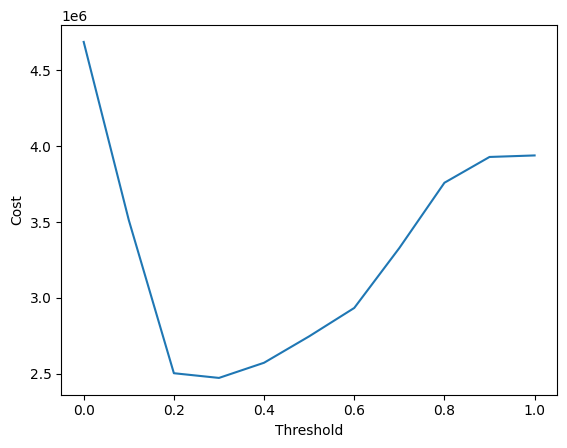

2025/04/24 20:46:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhor arquitetura: (20,), LR: 0.0001
Acurácia: 0.820 | F1: 0.470
Total cost (0.5): 2747000
Threshold com custo mínimo: 0.30 | Custo: 2473000


In [34]:
with mlflow.start_run(run_name="Neural Network - MLPClassifier"):
    # Modelo base e parâmetros
    mlp = MLPClassifier(solver='lbfgs', random_state=seed, max_iter=1000)
    parameters = {
        'hidden_layer_sizes': [(20,), (20,10), (20,10,2)],
        'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
    }

    # GridSearchCV
    clf_mlp = GridSearchCV(mlp, parameters, cv=5).fit(X_train, y_train)

    # Previsões
    y_preds_proba = clf_mlp.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    # Métricas clássicas
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Métricas de custo
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)
    if threshold_min_cost is not None:
        cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)
    else:
        threshold_min_cost = -1
        cost_at_min = -1

    # Registo no MLflow
    mlflow.log_param("model", "MLPClassifier")
    mlflow.log_param("best_hidden_layers", clf_mlp.best_params_['hidden_layer_sizes'])
    mlflow.log_param("best_learning_rate", clf_mlp.best_params_['learning_rate_init'])

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Guardar o modelo
    mlflow.sklearn.log_model(clf_mlp.best_estimator_, "model")

    # Print resumo
    print(f"Melhor arquitetura: {clf_mlp.best_params_['hidden_layer_sizes']}, LR: {clf_mlp.best_params_['learning_rate_init']}")
    print(f"Acurácia: {acc:.3f} | F1: {f1:.3f}")
    print(f"Total cost (0.5): {cost_0_5}")
    print(f"Threshold com custo mínimo: {threshold_min_cost:.2f} | Custo: {cost_at_min}")


Resultado quase igual às random forests!

#### 3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?

- A métrica usada foi o custo total uma vez que o objetivo do modelo era diminuir os custos do banco. O Modelo que levou a melhores resultados foram as neural networks e as random forests - 2,467,000 de custo.  
- Visto que com as neural networks não consigo saber qual a importancia das features, vou eleger o modelo de random forests como a solução final. Para além disso o treino das neural networks demorou quase o dobro do tempo.

#### Registar o melhor modelo (Random Forest) com o nome RumosBankFinalModel no Model Registry

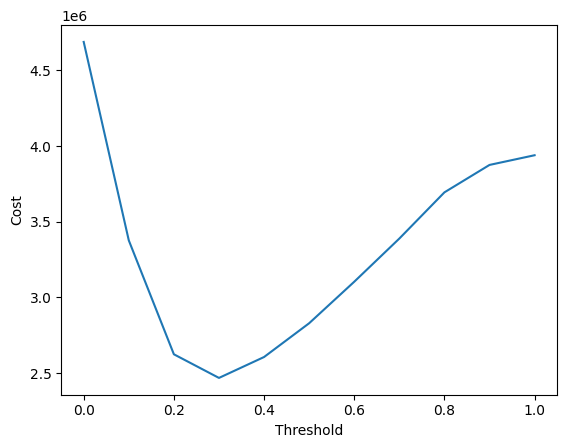

2025/04/25 10:30:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RumosBankFinalModel' already exists. Creating a new version of this model...
Created version '2' of model 'RumosBankFinalModel'.


In [36]:
with mlflow.start_run(run_name="Final Model - Random Forest"):
    # Calcular métricas novamente (caso já não estejam na memória)
    y_preds_proba = clf_rf.predict_proba(X_test)[:, 1]
    y_preds = (y_preds_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    cost_0_5 = total_cost(y_test, y_preds_proba, threshold=0.5)
    threshold_min_cost = min_cost_threshold(y_test, y_preds_proba)
    cost_at_min = total_cost(y_test, y_preds_proba, threshold=threshold_min_cost)

    # Registar parâmetros e métricas
    mlflow.log_param("model", "RandomForestClassifier")
    mlflow.log_param("best_n_estimators", clf_rf.best_params_['n_estimators'])
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("cost_at_0.5", cost_0_5)
    mlflow.log_metric("threshold_min_cost", threshold_min_cost)
    mlflow.log_metric("min_cost_value", cost_at_min)

    # Registar modelo no Registry
    mlflow.sklearn.log_model(
        clf_rf.best_estimator_,
        artifact_path="model",
        registered_model_name="RumosBankFinalModel"
    )



#### 4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?

In [62]:
rf = RandomForestClassifier(**clf_rf.best_params_).fit(X_train, y_train)

In [63]:
important_features = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns, columns = ['value'])
important_features.sort_values(by = 'value', ascending = False)

,value
PAY_0,0.097822
AGE,0.066125
BILL_AMT1,0.060066
LIMIT_BAL,0.059439
BILL_AMT2,0.054215
BILL_AMT3,0.051925
PAY_AMT1,0.050963
BILL_AMT4,0.050404
BILL_AMT6,0.050221
BILL_AMT5,0.049886


As variaveis que mais contribuem para o modelo decidir se um cliente vai ser um bom ou mau pagador são:
    - PAY_0 - Repayment status in September, 2005 
    - e AGE - idade do cliente
    

#### 5. Qual seria o custo que o banco tem sem nenhum modelo?

    - O custo que o banco teria sem modelo, ou seja, assumindo que todos os clientes seriam bons pagadores, é de: 3,939,000 Euros.

#### 6. Qual o custo que o banco passa a tar com o vosso modelo?

- O custo que o banco teria com o modelo seria de: 2,476,000 Euros - Pouparia quase 1 Milhão e meio de Euros!